# Collapsed Gibbs sampler for binary logistic supervised latent Dirichlet allocation

<div style="display:none">
  $
      \DeclareMathOperator{\dir}{Dirichlet}
      \DeclareMathOperator{\dis}{Discrete}
      \DeclareMathOperator{\normal}{Normal}
      \DeclareMathOperator{\ber}{Bernoulli}
      \DeclareMathOperator{\diag}{diag}
      \DeclareMathOperator{\Betaf}{B}
      \DeclareMathOperator{\Gammaf}{\Gamma}
      \DeclareMathOperator{\PG}{PG}
      \newcommand{\norm}[1]{\left\| #1 \right\|}
      \newcommand{\cp}[2]{p \left( #1 \middle| #2 \right)}
      \newcommand{\cN}[2]{\mathscr{N} \left( #1 \middle| #2 \right)}
      \newcommand{\cpsi}[2]{\psi \left( #1 \middle| #2 \right)}
      \newcommand{\cPsi}[2]{\Psi \left( #1 \middle| #2 \right)}
      \newcommand{\etd}[1]{\mathbf{z}^{(#1)}}
      \newcommand{\sumetd}{\mathbf{z}}
      \newcommand{\one}{\mathbf{1}}
  $
</div>

Here is the collapsed Gibbs sampler for Zhu et al.'s [improved Bayesian logistic supervised topic model with data augmentation](http://arxiv.org/pdf/1310.2408v1.pdf).  I am building on the [collapsed Gibbs sampler](http://nbviewer.savvysherpa.com/github/gp-0058-clt-at-toys-r-us/relational-topic-models/blob/master/slda.ipynb) I wrote for supervised latent Dirichlet allocation.

The generative model for BLSLDA is as follows:

$$\begin{align}
\theta^{(d)} &\sim \dir(\alpha) &\text{(topic distribution for document $d \in \{1, \ldots, D\}$)} \\
\phi^{(k)} &\sim \dir(\beta) &\text{(term distribution for topic $k \in \{1, \ldots, K\}$)} \\
z_n^{(d)} \mid \theta^{(d)} &\sim \dis \left( \theta^{(d)} \right) &\text{(topic of $n$th token of document $d$, $n \in \{1, \ldots, N^{(d)}\}$)} \\
w_n^{(d)} \mid \phi^{(z_n^{(d)})} &\sim \dis \left( \phi^{(z_n^{(d)})} \right) &\text{(term of $n$th token of document $d$, $n \in \{1, \ldots, N^{(d)}\}$)} \\
\eta_k &\sim \normal \left( \mu, \nu^2 \right) &\text{(regression coefficient for topic $k \in \{1, \ldots, K\}$)} \\
y^{(d)} \mid \eta, \etd{d} &\sim \ber \left( \frac{ \exp \left( \eta \cdot \etd{d} \right) }{ 1 + \exp \left( \eta \cdot \etd{d} \right) } \right) &\text{(response value of document $d \in \{1, \ldots, D\}$)}
\end{align}$$

where each token can be any one of $V$ terms in our vocabulary, and $\etd{d}$ is the empirical topic distribution of document $d$.

<img src="http://www.mdpi.com/remotesensing/remotesensing-05-02275/article_deploy/html/images/remotesensing-05-02275f2-1024.png" width="400">

<p style='text-align: center; font-style: italic;'>
Plate notation for supervised latent Dirichlet allocation.
<br/>
This diagram should replace $\beta_k$ with $\phi^{(k)}$, and each $\phi^{(k)}$ should be dependent on a single $\beta$.
</p>

Following [Zhu et al. 2013](http://arxiv.org/pdf/1310.2408v1.pdf), the regularized pseudo-likelihood for the response variable $y^{(d)}$, with regularization parameter $b \ge 0$, can be written

$$\begin{align}
\cpsi{y^{(d)}}{\eta, \etd{d}, b}
&= \cp{y^{(d)}}{\eta, \etd{d}}^b
\\ &= \left( \frac{\exp \left( \eta \cdot \etd{d} \right)^{y^{(d)}}}{ 1 + \exp \left( \eta \cdot \etd{d} \right)} \right)^b
\\ &= \frac{\exp \left( b y^{(d)} (\eta \cdot \etd{d}) \right)}
{ \left( \exp \left( -\frac{\eta \cdot \etd{d}}{2} \right) + \exp \left( \frac{ \eta \cdot \etd{d} }{2} \right) \right)^b \exp \left( \frac{b}{2} (\eta \cdot \etd{d}) \right) }
\\ &= 2^{-b} \exp \left( b \left( y^{(d)} - \frac{1}{2} \right) \left( \eta \cdot \etd{d} \right) \right) \cosh \left( \frac{ \eta \cdot \etd{d} }{2} \right)^{-b}
\\ &= 2^{-b} \exp \left( b \left( y^{(d)} - \frac{1}{2} \right) \left( \eta \cdot \etd{d} \right) \right)
\int_0^\infty \exp \left( -\frac{ \left( \eta \cdot \etd{d} \right)^2 }{2} \omega^{(d)} \right)
\cp{\omega^{(d)}}{b, 0} d\omega^{(d)}
\end{align}$$

where $\omega^{(d)}$ is a Polya-Gamma distributed variable with parameters $b = b$ and $c = 0$ (see [Polson et al. 2012](http://arxiv.org/pdf/1205.0310v3.pdf) for details).  This means that, for each document $d$, the pseudo-likelihood of $y^{(d)}$ is actually a mixture of Gaussians with respect to the Polya-Gamma distribution $\PG(b, 0)$.  Therefore, the joint pseudo-likelihood of $y^{(d)}$ and $\omega^{(d)}$ can be written

$$\cPsi{y^{(d)}, \omega^{(d)}}{\eta, \etd{d}, b}
= 2^{-b} \exp \left( \kappa^{(d)} \zeta^{(d)} - \frac{ \omega^{(d)} }{2} (\zeta^{(d)})^2 \right) \cp{\omega^{(d)}}{b, 0}.$$

where $\kappa^{(d)} = b(y^{(d)} - 1/2)$ and $\zeta^{(d)} = \eta \cdot \etd{d}$.  The joint probability distribution can therefore be factored as follows:

$$\begin{align}
\cp{\theta, \phi, z, w, \eta, y, \omega}{\alpha, \beta, \mu, \nu^2, b}
&= 
\prod_{k=1}^{K} \cp{\phi^{(k)}}{\beta}
\prod_{d=1}^{D} \cp{\theta^{(d)}}{\alpha}
\prod_{n=1}^{N^{(d)}} \cp{z_n^{(d)}}{\theta^{(d)}} \cp{w_n^{(d)}}{\phi^{(z_n^{(d)})}}
\\ & \quad \times \prod_{k'=1}^{K} \cp{\eta_{k'}}{\mu, \nu^2}
\prod_{d'=1}^D \cPsi{y^{(d')}, \omega^{(d')}}{\eta, \etd{d'}, b}
\\ &=
\prod_{k=1}^{K} \frac{\Betaf(b^{(k)} + \beta)}{\Betaf(\beta)} \cp{\phi^{(k)}}{b^{(k)} + \beta}
\prod_{d=1}^{D} \frac{\Betaf(a^{(d)} + \alpha)}{\Betaf(\alpha)} \cp{\theta^{(d)}}{a^{(d)} + \alpha}
\\ &\quad \times
\prod_{k'=1}^{K} \cN{\eta_{k'}}{\mu, \nu^2} 
\prod_{d'=1}^{D} 2^{-b} \exp \left( \kappa^{(d')} \zeta^{(d')} - \frac{ \omega^{(d')} }{2} (\zeta^{(d')})^2 \right) \cp{\omega^{(d')}}{b, 0}
\end{align}$$

where $a_k^{(d)}$ is the number of tokens in document $d$ assigned to topic $k$, $b_v^{(k)}$ is the number of tokens equal to term $v$ and assigned to topic $k$, and $\Betaf$ is the [multivariate Beta function](https://en.wikipedia.org/wiki/Beta_function#Multivariate_beta_function). Marginalizing out $\theta$ and $\phi$ by integrating with respect to each $\theta^{(d)}$ and $\phi^{(k)}$ over their respective sample spaces yields

$$\begin{align}
\cp{z, w, \eta, y, \omega}{\alpha, \beta, \mu, \nu^2, b}
&= 
\prod_{k=1}^{K} \frac{\Betaf(b^{(k)} + \beta)}{\Betaf(\beta)}
\prod_{d=1}^{D} \frac{\Betaf(a^{(d)} + \alpha)}{\Betaf(\alpha)}
\prod_{k'=1}^{K} \cN{\eta_{k'}}{\mu, \nu^2} 
\prod_{d'=1}^{D} 2^{-b} \exp \left( \kappa^{(d')} \zeta^{(d')} - \frac{ \omega^{(d')} }{2} (\zeta^{(d')})^2 \right) \cp{\omega^{(d')}}{b, 0}
\\ &=
\cp{w}{z, \beta} \cp{z}{\alpha} \cp{\eta}{\mu, \nu^2} \cPsi{y, \omega}{\eta, z, b}.
\end{align}$$

See my [LDA notebook](http://nbviewer.savvysherpa.com/github/bearnshaw/ml-demos/blob/master/lda_gibbs_sampling_cython.ipynb) for step-by-step details of the previous two calculations.

Our goal is to calculate the posterior distribution

$$\cp{z, \eta, \omega}{w, y, \alpha, \beta, \mu, \nu^2, b} =
\frac{\cp{z, w, \eta, y, \omega}{\alpha, \beta, \mu, \nu^2, b}}
{\sum_{z'} \iint \cp{z', w, \eta', y, \omega{'}}{\alpha, \beta, \mu, \nu^2, b} d\eta' d\omega{'}}$$

in order to infer the topic assignments $z$ and regression coefficients $\eta$ from the given term assignments $w$ and response data $y$.  Since calculating this directly is infeasible, we resort to collapsed Gibbs sampling.  The sampler is "collapsed" because we marginalized out $\theta$ and $\phi$, and will estimate them from the topic assignments $z$:

$$\hat\theta_k^{(d)} = \frac{a_k^{(d)} + \alpha_k}{\sum_{k'=1}^K \left(a_{k'}^{(d)} + \alpha_{k'} \right)},\quad
\hat\phi_v^{(k)} = \frac{b_v^{(k)} + \beta_v}{\sum_{v'=1}^V \left(b_{v'}^{(k)} + \beta_{v'} \right)}.$$

Gibbs sampling requires us to compute the full conditionals for each $z_n^{(d)}$, $\omega^{(d)}$ and $\eta_k$.  For example, we need to calculate, for all $n$, $d$ and $k$,

$$\begin{align}
\cp{z_n^{(d)} = k}{z \setminus z_n^{(d)}, w, \eta, y, \omega, \alpha, \beta, \mu, \nu^2, b}
&\propto
\cp{z_n^{(d)} = k, z \setminus z_n^{(d)}, w, \eta, y, \omega}{\alpha, \beta, \mu, \nu^2, b}
\\ &\propto
\frac{b_{w_n^{(d)}}^{(k)} \setminus z_n^{(d)} + \beta_{w_n^{(d)}}}{ \sum_{v=1}^V \left( b_v^{(k)} \setminus z_n^{(d)} + \beta_v\right)}
\left( a_k^{(d)} \setminus z_n^{(d)} + \alpha_k \right)
\prod_{d'=1}^{D} \exp \left( \kappa^{(d')} \zeta^{(d')} - \frac{ \omega^{(d')} }{2} (\zeta^{(d')})^2 \right)
\\ &\propto
\frac{b_{w_n^{(d)}}^{(k)} \setminus z_n^{(d)} + \beta_{w_n^{(d)}}}{ \sum_{v=1}^V \left( b_v^{(k)} \setminus z_n^{(d)} + \beta_v\right)}
\left( a_k^{(d)} \setminus z_n^{(d)} + \alpha_k \right)
\\ &\quad \times \exp \left( \left( \kappa^{(d)} - \omega^{(d)} (\zeta^{(d)} \setminus z_n^{(d)}) \right) \frac{\eta_k}{N^{(d)}}
- \frac{\omega^{(d)}}{2} \left( \frac{\eta_k}{N^{(d)}} \right)^2 \right)
\end{align}$$

where the "set-minus" notation $\cdot \setminus z_n^{(d)}$ denotes the variable the notation is applied to with the entry $z_n^{(d)}$ removed (again, see my [LDA notebook](http://nbviewer.savvysherpa.com/github/bearnshaw/ml-demos/blob/master/lda_gibbs_sampling_cython.ipynb) for details).  This final proportionality is true since

$$\begin{align}
\prod_{d'=1}^{D} \exp \left( \kappa^{(d')} \zeta^{(d')} - \frac{ \omega^{(d')} }{2} (\zeta^{(d')})^2 \right)
&=
\prod_{d'=1}^{D} \exp \left( \kappa^{(d')} \left( \zeta^{(d')} \setminus z_n^{(d)} + \delta_{d, d'} \frac{\eta_k}{N^{(d)}} \right)
- \frac{ \omega^{(d')} }{2} \left( \zeta^{(d')} \setminus z_n^{(d)} + \delta_{d, d'} \frac{\eta_k}{N^{(d)}} \right)^2 \right)
\\ &\propto
\exp \left( \kappa^{(d)} \left( \zeta^{(d)} \setminus z_n^{(d)} + \frac{\eta_k}{N^{(d)}} \right)
- \frac{ \omega^{(d)} }{2} \left( \zeta^{(d)} \setminus z_n^{(d)} + \frac{\eta_k}{N^{(d)}} \right)^2 \right)
\\ &\propto
\exp \left( \left( \kappa^{(d)} - \omega^{(d)} (\zeta^{(d)} \setminus z_n^{(d)}) \right) \frac{\eta_k}{N^{(d)}}
- \frac{\omega^{(d)}}{2} \left( \frac{\eta_k}{N^{(d)}} \right)^2 \right)
\end{align}$$

where $\delta_{d, d'}$ is the [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta).

In order to calculate the full conditional for $\eta$, let $Z = (\etd{1} \cdots \etd{D})$ be the matrix whose $d$th column is $\etd{d}$, $\Omega = \diag(\omega^{(1)}, \ldots, \omega^{(D)})$ be the diagonal matrix whose $d$th diagonal entry is $\omega^{(d)}$, $I$ be the identity matrix, and $\one$ be the vector of ones, and note that

$$\prod_{k=1}^{K} \cN{\eta_{k}}{\mu, \nu^2} = \cN{\eta}{\mu \one, \nu^2 I}$$
$$\prod_{d=1}^{D} \exp \left( \kappa^{(d)} \zeta^{(d)} - \frac{ \omega^{(d)} }{2} (\zeta^{(d)})^2 \right)
= \exp \left( \eta^T Z \kappa - \frac{1}{2} \eta^T Z \Omega Z^T \eta \right)
\propto \cN{\eta}{(Z \Omega Z^T)^{-1} Z \kappa, (Z \Omega Z^T)^{-1}}.$$

Therefore

$$\begin{align}
\cp{\eta}{z, w, y, \omega, \alpha, \beta, \mu, \nu^2, b}
&\propto
\cp{z, w, \eta, y, \omega}{\alpha, \beta, \mu, \nu^2, b}
\\ &\propto
\cN{\eta}{\mu \one, \nu^2 I} \cN{\eta}{(Z \Omega Z^T)^{-1} Z \kappa, (Z \Omega Z^T)^{-1}}
\\ &\propto
\cN{\eta}{\Sigma \left( \frac{\mu}{\nu^2} \one + Z \kappa \right), \Sigma}
\end{align}$$

where $\Sigma^{-1} = \nu^{-2} I + Z \Omega Z^T$ (see Section 8.1.8 of the [Matrix Cookbook](http://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf)).

We also need to calculate the full conditional for $\omega$.  We calculate

$$\begin{align}
\cp{\omega}{z, w, \eta, y, \alpha, \beta, \mu, \nu^2, b}
&\propto

\cp{z, w, \eta, y, \omega}{\alpha, \beta, \mu, \nu^2, b}
\\ &\propto
\prod_{d=1}^D \exp \left( - \frac{ \omega^{(d)} }{2} (\zeta^{(d)})^2 \right) \cp{\omega^{(d)}}{b, 0}
\\ &=
\prod_{d=1}^D \cp{\omega^{(d)}}{b, \zeta^{(d)}}
\end{align}$$

that is, $\omega^{(d)} \sim \PG(b, \eta \cdot \etd{d})$ for each $d$.  We sample from the Polya-Gamma distribution according to the method of [Polson et al. 2012](http://arxiv.org/pdf/1205.0310.pdf), implemented for Python 3 in this [code repo](https://github.com/marekpetrik/pypolyagamma).

## Graphical test 

In [1]:
%matplotlib inline

from modules.helpers import plot_images
from functools import partial
from sklearn.metrics import (roc_auc_score, roc_curve)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

imshow = partial(plt.imshow, cmap='gray', interpolation='nearest', aspect='auto')
sns.set(style='white')

### Generate topics 

We assume a vocabulary of 25 terms, and create ten "topics", where each topic assigns exactly 5 consecutive terms equal probability.

In [2]:
V = 25
K = 10
N = 100
D = 1000

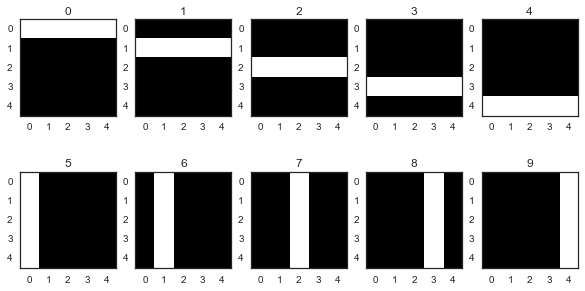

In [3]:
topics = []
topic_base = np.concatenate((np.ones((1, 5)) * 0.2, np.zeros((4, 5))), axis=0).ravel()
for i in range(5):
    topics.append(np.roll(topic_base, i * 5))
topic_base = np.concatenate((np.ones((5, 1)) * 0.2, np.zeros((5, 4))), axis=1).ravel()
for i in range(5):
    topics.append(np.roll(topic_base, i))
topics = np.array(topics)
plt.figure(figsize=(10, 5))
plot_images(plt, topics, (5, 5), layout=(2, 5), figsize=(10, 5))

### Generate documents from topics

We generate 1,000 documents from these 10 topics by sampling 1,000 topic distributions, one for each document, from a Dirichlet distribution with parameter $\alpha = (1, \ldots, 1)$.

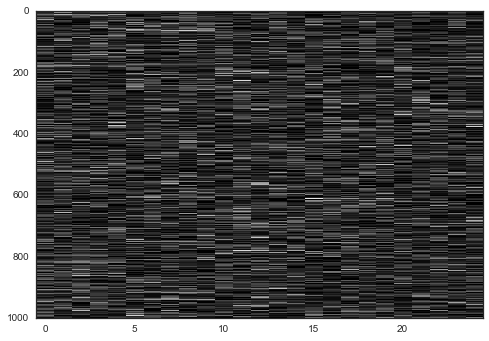

In [4]:
alpha = np.repeat(1., K)
np.random.seed(42)
thetas = np.random.dirichlet(alpha, size=D)
topic_assignments = np.array([np.random.choice(range(K), size=100, p=theta)
                              for theta in thetas])
word_assignments = np.array([[np.random.choice(range(V), size=1, p=topics[topic_assignments[d, n]])[0]
                              for n in range(N)] for d in range(D)])
doc_term_matrix = np.array([np.histogram(word_assignments[d], bins=V, range=(0, V - 1))[0] for d in range(D)])
imshow(doc_term_matrix)

### Generate responses

[ 0.05056171  0.49995133 -0.99590893  0.69359851 -0.41830152 -1.58457724
 -0.64770677  0.59857517  0.33225003 -1.14747663]


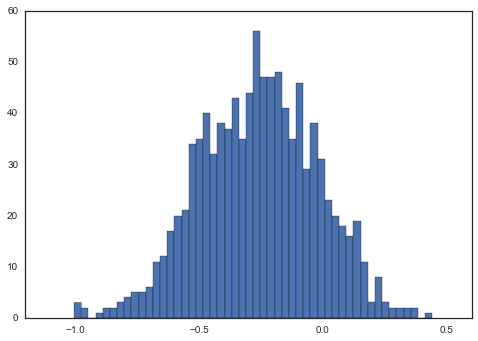

In [5]:
# choose parameter values
mu = 0.
nu2 = 1.
np.random.seed(4)
eta = np.random.normal(loc=mu, scale=nu2, size=K)
print(eta)
# plot histogram of pre-responses
zeta = np.array([np.dot(eta, thetas[i]) for i in range(D)])
_ = plt.hist(zeta, bins=50)

positive examples 138 (13.8%)


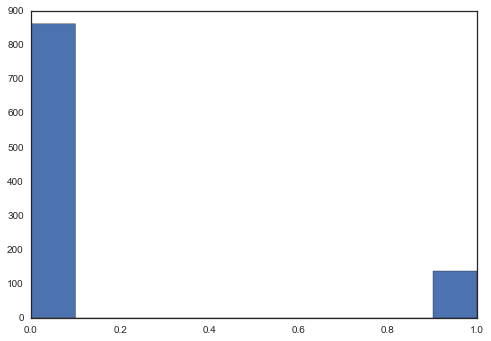

In [6]:
# choose parameter values
y = (zeta >= 0).astype(int)
# plot histogram of responses
print('positive examples {} ({:.1f}%)'.format(y.sum(), y.sum() / D * 100))
_ = plt.hist(y)

### Estimate parameters

In [7]:
from lda_cython.topic_models import BLSLDA

ImportError: dlopen(/Users/mattburbidge/anaconda3/envs/lda-cython/lib/python3.5/site-packages/pypolyagamma/pypolyagamma.cpython-35m-darwin.so, 2): Library not loaded: @rpath/./libgomp.1.dylib
  Referenced from: /Users/mattburbidge/anaconda3/envs/lda-cython/lib/python3.5/site-packages/pypolyagamma/pypolyagamma.cpython-35m-darwin.so
  Reason: image not found

In [ ]:
_K = 10
_alpha = alpha
_beta = np.repeat(0.01, V)
_mu = mu
_nu2 = nu2
_b = 7.25
n_iter = 500
blslda = BLSLDA(_K, _alpha, _beta, _mu, _nu2, _b, n_iter, seed=42)

In [ ]:
%%time
blslda.fit(doc_term_matrix, y)

In [ ]:
plot_images(plt, blslda.phi, (5, 5), (2, 5), figsize=(10, 5))

In [ ]:
topic_order = [1, 7, 0, 3, 6, 4, 9, 5, 2, 8]
plot_images(plt, blslda.phi[topic_order], (5, 5), (2, 5), figsize=(10, 5))

In [ ]:
imshow(blslda.theta)

In [ ]:
plt.plot(blslda.loglikelihoods)

In [ ]:
burn_in = 300 #max(n_iter - 100, int(n_iter / 2))
blslda.loglikelihoods[burn_in:].mean()

In [ ]:
eta_pred = blslda.eta[burn_in:].mean(axis=0)
print(eta_pred)

In [ ]:
print(eta_pred[topic_order])
print(eta)

### Predict response of test documents

Create 1,000 test documents using the same generative process as our training documents, and compute their actual responses.

In [ ]:
np.random.seed(42^2)
thetas_test = np.random.dirichlet(alpha, size=D)
topic_assignments_test = np.array([np.random.choice(range(K), size=100, p=theta)
                                   for theta in thetas_test])
word_assignments_test = np.array([[np.random.choice(range(V), size=1, p=topics[topic_assignments_test[d, n]])[0]
                                   for n in range(N)] for d in range(D)])
doc_term_matrix_test = np.array([np.histogram(word_assignments_test[d], bins=V, range=(0, V - 1))[0] for d in range(D)])
y_test = np.array([np.dot(eta, thetas_test[i]) >= 0 for i in range(D)], dtype=int)
imshow(doc_term_matrix_test)

Estimate their topic distributions using the trained model, then calculate the predicted responses using the mean of our samples of $\eta$ after burn-in as an estimate for $\eta$.

In [ ]:
def bern_param(eta, theta):
    return np.exp(np.dot(eta, theta)) / (1 + np.exp(np.dot(eta, theta)))

In [ ]:
thetas_test_blslda = blslda.transform(doc_term_matrix_test)
y_blslda = [bern_param(eta_pred, thetas_test_blslda[i]) for i in range(D)]
_ = plt.hist(y_blslda, bins=30)

Measure the goodness of our prediction using [area under the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_blslda)
plt.plot(fpr, tpr, label=('AUC = {:.3f}'.format(roc_auc_score(y_test, y_blslda))))
_ = plt.legend(loc='best')

### Find best b

In [ ]:
_b_grid = np.arange(1, 10, 1)
roc_auc_scores = []
for _b in _b_grid:
    print('Training BLSLDA with b = {}'.format(_b))
    _blslda = BLSLDA(_K, _alpha, _beta, _mu, _nu2, _b, n_iter, seed=42, verbose=False)
    _blslda.fit(doc_term_matrix, y)
    _thetas_test_blslda = _blslda.transform(doc_term_matrix_test)
    _eta_pred = _blslda.eta[burn_in:].mean(axis=0)
    _y_blslda = [bern_param(_eta_pred, _thetas_test_blslda[i]) for i in range(D)]
    roc_auc_scores.append(roc_auc_score(y_test, _y_blslda))
    print('  roc_auc_score = {}'.format(roc_auc_scores[-1]))
print(_b_grid[np.argmax(roc_auc_scores)], np.max(roc_auc_scores))
plt.plot(_b_grid, roc_auc_scores)

In [ ]:
_b_grid = np.arange(7, 8, .1)
roc_auc_scores = []
for _b in _b_grid:
    print('Training BLSLDA with b = {}'.format(_b))
    _blslda = BLSLDA(_K, _alpha, _beta, _mu, _nu2, _b, n_iter, seed=42, verbose=False)
    _blslda.fit(doc_term_matrix, y)
    _thetas_test_blslda = _blslda.transform(doc_term_matrix_test)
    _eta_pred = _blslda.eta[burn_in:].mean(axis=0)
    _y_blslda = [bern_param(_eta_pred, _thetas_test_blslda[i]) for i in range(D)]
    roc_auc_scores.append(roc_auc_score(y_test, _y_blslda))
    print('  roc_auc_score = {}'.format(roc_auc_scores[-1]))
print(_b_grid[np.argmax(roc_auc_scores)], np.max(roc_auc_scores))
plt.plot(_b_grid, roc_auc_scores)

### Two-step learning: learn topics, then learn regression

In [ ]:
from lda_cython.topic_models import LDA

In [ ]:
lda = LDA(_K, _alpha, _beta, n_iter, seed=42)

In [ ]:
%%time
lda.fit(doc_term_matrix)

In [ ]:
plot_images(plt, lda.phi, (5, 5), (2, 5), figsize=(10, 5))

In [ ]:
imshow(lda.theta)

In [ ]:
plt.plot(lda.loglikelihoods)

In [ ]:
thetas_test_lda = lda.transform(doc_term_matrix_test)

#### L2-regularized logistic regression

- train logistic regression on training data
- calculate response on test data
- measure the goodness of prediction using area under the ROC curve

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
_C_grid = np.arange(0.001, 100, 1)
roc_auc_scores = []
for _C in _C_grid:
    print('Training Logistic Regression with C = {}'.format(_C))
    _lr = LogisticRegression(fit_intercept=False, C=_C)
    _lr.fit(lda.theta, y)
    _y_lr = _lr.predict_proba(thetas_test_lda)[:, 1]
    roc_auc_scores.append(roc_auc_score(y_test, _y_lr))
    print('  roc_auc_score = {}'.format(roc_auc_scores[-1]))
print(_C_grid[np.argmax(roc_auc_scores)], np.max(roc_auc_scores))
plt.plot(_C_grid, roc_auc_scores)

In [ ]:
lr = LogisticRegression(fit_intercept=False, C=39)
lr.fit(lda.theta, y)
y_lr = lr.predict_proba(thetas_test_lda)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_lr)
plt.plot(fpr, tpr, label=('AUC = {:.3f}'.format(roc_auc_score(y_test, y_lr))))
_ = plt.legend(loc='best')

#### Gradient boosted trees

- train gradient boosted trees on training data
- calculate response on test data
- measure the goodness of prediction using area under the ROC

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbr = GradientBoostingClassifier()
gbr.fit(lda.theta, y)
y_gbr = gbr.predict_proba(thetas_test_lda)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_gbr)
plt.plot(fpr, tpr, label=('AUC = {:.3f}'.format(roc_auc_score(y_test, y_gbr))))
_ = plt.legend(loc='best')

### Conclusion

The best BLSLDA is slightly better than the best logistic regression, and better than gradient boosted regression trees.  The similar performance to logistic regression is likely due to the fact that this test was set up as an exact problem - all parameters used in training, except $\beta$ (because we hand-picked the topics) and $\eta$ (because that was the one parameter we wanted to learn), were those used to generate documents.

## Test with fewer topics

We now redo the previous test, but this time with fewer topics, in order to determine whether

1. the supervised portion of BLSLDA will produce topics different from those produced by LDA, and
1. prediction with SLDA is improved over LDA-and-a-regression.

Because we will no longer be solving an exact problem (the number of topics, and hence $\alpha$, will both be different from the document generation process), we expect BLSLDA to do better than LDA-and-a-regression, including unregularized linear regression.

In [ ]:
_K = 5
_alpha = np.repeat(1., _K)

In [ ]:
_b_grid = np.arange(1, 10, 1)
roc_auc_scores = []
for _b in _b_grid:
    print('Training BLSLDA with b = {}'.format(_b))
    _blslda = BLSLDA(_K, _alpha, _beta, _mu, _nu2, _b, n_iter, seed=42, verbose=False)
    _blslda.fit(doc_term_matrix, y)
    _thetas_test_blslda = _blslda.transform(doc_term_matrix_test)
    _eta_pred = _blslda.eta[burn_in:].mean(axis=0)
    _y_blslda = [bern_param(_eta_pred, _thetas_test_blslda[i]) for i in range(D)]
    roc_auc_scores.append(roc_auc_score(y_test, _y_blslda))
    print('  roc_auc_score = {}'.format(roc_auc_scores[-1]))
print(_b_grid[np.argmax(roc_auc_scores)], np.max(roc_auc_scores))
plt.plot(_b_grid, roc_auc_scores)

In [ ]:
_b_grid = np.arange(9, 11, 0.2)
roc_auc_scores = []
for _b in _b_grid:
    print('Training BLSLDA with b = {}'.format(_b))
    _blslda = BLSLDA(_K, _alpha, _beta, _mu, _nu2, _b, n_iter, seed=42, verbose=False)
    _blslda.fit(doc_term_matrix, y)
    _thetas_test_blslda = _blslda.transform(doc_term_matrix_test)
    _eta_pred = _blslda.eta[burn_in:].mean(axis=0)
    _y_blslda = [bern_param(_eta_pred, _thetas_test_blslda[i]) for i in range(D)]
    roc_auc_scores.append(roc_auc_score(y_test, _y_blslda))
    print('  roc_auc_score = {}'.format(roc_auc_scores[-1]))
print(_b_grid[np.argmax(roc_auc_scores)], np.max(roc_auc_scores))
plt.plot(_b_grid, roc_auc_scores)

In [ ]:
_b = 9
n_iter = 1000
blslda1 = BLSLDA(_K, _alpha, _beta, _mu, _nu2, _b, n_iter, seed=42)

In [ ]:
%%time
blslda1.fit(doc_term_matrix, y)

In [ ]:
plot_images(plt, blslda1.phi, (5, 5), (1, 5), figsize=(10, 5))

In [ ]:
imshow(blslda1.theta)

In [ ]:
plt.plot(blslda1.loglikelihoods)

In [ ]:
burn_in1 = 600
blslda1.loglikelihoods[burn_in1:].mean()

In [ ]:
eta_pred1 = blslda1.eta[burn_in1:].mean(axis=0)
eta_pred1

In [ ]:
thetas_test_blslda1 = blslda1.transform(doc_term_matrix_test)
y_blslda1 = [bern_param(eta_pred1, thetas_test_blslda1[i]) for i in range(D)]

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_blslda1)
plt.plot(fpr, tpr, label=('AUC = {:.3f}'.format(roc_auc_score(y_test, y_blslda1))))
_ = plt.legend(loc='best')

In [ ]:
lda1 = LDA(_K, _alpha, _beta, n_iter, seed=42)

In [ ]:
%%time
lda1.fit(doc_term_matrix)

In [ ]:
plot_images(plt, lda1.phi, (5, 5), (1, 5), figsize=(10, 5))

We plot the SLDA topics again and note that they are indeed different!

In [ ]:
plot_images(plt, blslda1.phi, (5, 5), (1, 5), figsize=(10, 5))

In [ ]:
imshow(lda1.theta)

In [ ]:
plt.plot(lda1.loglikelihoods)

In [ ]:
thetas_test_lda1 = lda1.transform(doc_term_matrix_test)

#### L2-regularized linear regression

In [ ]:
_C_grid = np.arange(0.001, 100, 1)
roc_auc_scores = []
for _C in _C_grid:
    print('Training Logistic Regression with C = {}'.format(_C))
    _lr = LogisticRegression(fit_intercept=False, C=_C)
    _lr.fit(lda1.theta, y)
    _y_lr = _lr.predict_proba(thetas_test_lda1)[:, 1]
    roc_auc_scores.append(roc_auc_score(y_test, _y_lr))
    print('  roc_auc_score = {}'.format(roc_auc_scores[-1]))
print(_C_grid[np.argmax(roc_auc_scores)], np.max(roc_auc_scores))
plt.plot(_C_grid, roc_auc_scores)

In [ ]:
lr1 = LogisticRegression(fit_intercept=False, C=93)
lr1.fit(lda1.theta, y)
y_lr1 = lr1.predict_proba(thetas_test_lda1)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_lr1)
plt.plot(fpr, tpr, label=('AUC = {:.3f}'.format(roc_auc_score(y_test, y_lr1))))
_ = plt.legend(loc='best')

#### Gradient boosted trees

In [ ]:
gbr1 = GradientBoostingClassifier()
gbr1.fit(lda1.theta, y)
y_gbr1 = gbr1.predict_proba(thetas_test_lda1)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_gbr1)
plt.plot(fpr, tpr, label=('AUC = {:.3f}'.format(roc_auc_score(y_test, y_gbr1))))
_ = plt.legend(loc='best')

#### L2-regularized logistic regression with SLDA topics

In [ ]:
_C_grid = np.arange(0.001, 100, 1)
roc_auc_scores = []
for _C in _C_grid:
    print('Training Logistic Regression with C = {}'.format(_C))
    _lr = LogisticRegression(fit_intercept=False, C=_C)
    _lr.fit(blslda1.theta, y)
    _y_lr = _lr.predict_proba(thetas_test_blslda1)[:, 1]
    roc_auc_scores.append(roc_auc_score(y_test, _y_lr))
    print('  roc_auc_score = {}'.format(roc_auc_scores[-1]))
print(_C_grid[np.argmax(roc_auc_scores)], np.max(roc_auc_scores))
plt.plot(_C_grid, roc_auc_scores)

In [ ]:
lr1_0 = LogisticRegression(fit_intercept=False, C=34)
lr1_0.fit(blslda1.theta, y)
y_lr1_0 = lr1_0.predict_proba(thetas_test_blslda1)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_lr1_0)
plt.plot(fpr, tpr, label=('AUC = {:.3f}'.format(roc_auc_score(y_test, y_lr1_0))))
_ = plt.legend(loc='best')

#### Gradient boosted trees with SLDA topics

In [ ]:
gbr1_0 = GradientBoostingClassifier()
gbr1_0.fit(blslda1.theta, y)
y_gbr1_0 = gbr1_0.predict_proba(thetas_test_blslda1)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_gbr1_0)
plt.plot(fpr, tpr, label=('AUC = {:.3f}'.format(roc_auc_score(y_test, y_gbr1_0))))
_ = plt.legend(loc='best')

### Conclusion for test with fewer topics

BLSLDA performs at least 20% better in AUC than any of the LDA-and-a-regression methods, and similar to the BLSLDA-and-a-logistic-regression methods.